In [ ]:
import numpy as np
import pandas as pd
import os
os.chdir('..')
os.chdir('src')
from utils import *
from env import BlackjackEnv


In [11]:
config = {
    "num_decks": 6,
    "red_card_position": 0.2,
    "bet_size": [1, 4, 8],
    "actions": ["stand", "hit", "double", "split"],
    "num_players": 1,
    "max_splits": 3,
    "split_aces_only_one_card": True
}

env = BlackjackEnv(config)

### Parsing the necessary files

In [12]:
os.chdir('..')
os.chdir('strategies')
# Load the playing and betting strategies
basic_strat = parse_strategy_csv('basic_strat_doub.csv')
betting_strat = parse_betting_strategy_csv('q_table_bet_avg.csv')
dd_strat = parse_strategy_csv('dq_h_s_dd_strat.csv')
basic_split_strat = parse_split_strategy_csv('basic_split_strat.csv')

### Helper functions

In [13]:
def get_q_values(state_features, strategy_dict):
    """Get action values from a strategy dictionary for a given state"""
    if state_features in strategy_dict:
        q_values = np.zeros(3)  # Initialize with zeros for all possible actions
        for action, value in strategy_dict[state_features].items():
            if action < len(q_values):
                q_values[action] = value
        return q_values
    else:
        # Return default values based on player sum
        player_sum = state_features[0]
        if player_sum < 12:
            return np.array([-0.1, 0.5, 0.0])  # Default to hit for low sums
        elif player_sum >= 20:
            return np.array([0.5, -0.1, 0.0])  # Default to stand for high sums
        else:
            return np.array([0.0, 0.0, 0.0])  # Neutral for middle sums

In [14]:
def update_q_value(state_key, action, reward, next_state_key, lr, q_table=None, target_q_table=None, gamma=0.95, base_q_table=dd_strat):
    """Update Q-value for state-action pair using Double Q-learning with safeguards for missing keys"""
    # Current Q-value
    current_q = q_table[state_key][action]

    if reward > 1:
        reward = 1.2
    elif reward < -1:
        reward = -1.2

    if next_state_key in target_q_table:
        # Get the next state's best action from current Q-table
        next_q_values = target_q_table[next_state_key]
        next_max_q = max(next_q_values.values()) if next_q_values else 0
        
        # Formula Q-learning standard: ricompensa immediata + ricompensa futura scontata
        target = reward + gamma * next_max_q
    elif next_state_key in base_q_table:
        # If next_state_key is in base Q-table, use its value
        next_q_values = base_q_table[next_state_key]
        next_max_q = max(next_q_values.values()) if next_q_values else 0
        
        # Formula Q-learning standard: ricompensa immediata + ricompensa futura scontata
        target = reward + gamma * next_max_q
    else:
        # If next_state_key is not in either Q-table, use the reward only
        target = reward

    
    # Update the Q-value with the formula of standard update
    new_q = current_q + lr * (target - current_q)
    
    # Update the value in the Q-table
    q_table[state_key][action] = new_q
    
    return q_table

In [15]:
def smart_exploration(state_key, epsilon, q_table_1, q_table_2, state_visits):
    """Smart exploration strategy with state visit tracking"""
    # Count-based exploration bonus
    visit_count = state_visits[state_key]
    exploration_bonus = 1.0 / (1.0 + visit_count / 1000)
    adjusted_epsilon = min(0.9, epsilon + exploration_bonus)
    
    # Update visit count for this state
    state_visits[state_key] += 1
    # Decide whether to explore or exploit
    if np.random.rand() < adjusted_epsilon:
        # Explore randomly
        return np.random.choice([0, 1])
    else:
        # Exploit: use average of both Q-tables
        avg_q_values = {
            action: (q_table_1[state_key][action] + q_table_2[state_key][action]) / 2
            for action in [0, 1]
        }
        return max(avg_q_values, key=avg_q_values.get)
    

### Q-table initialization for splitting

In [16]:
# Initialize Q-tables for splitting strategy
q_table_split_1 = {}
q_table_split_2 = {}

# For each possible pair (2-9, T, A) and dealer upcard (2-10, A)
for pair_value in range(2, 12):  # 2-10, 11 (Ace)
    for dealer_upcard in range(2, 12):  # 2-10, 11 (Ace)
        # Create a state key for the pair
        state_key = (pair_value, dealer_upcard)
        
        # Initialize Q-values for split vs. no-split
        # We'll use 0 for "don't split" and 1 for "split"
        q_table_split_1[state_key] = {0: -0.1, 1: -0.1}  # 0=don't split, 1=split
        q_table_split_2[state_key] = {0: -0.1, 1: -0.1}  # 0=don't split, 1=split

# State visit tracking for exploration bias
state_visits = {state_key: 0 for state_key in q_table_split_1.keys()}

### Hyperparameters

In [17]:
### Hyperparameters
initial_alpha = 0.1      # Starting learning rate
min_alpha = 0.01         # Minimum learning rate
decay_rate = 0.999997    # Decay rate for learning rate
gamma = 1.0              # Discount factor
starting_epsilon = 1.0   # Exploration rate
epsilon_decay = 0.999995 # Decay rate for exploration
min_epsilon = 0.01       # Minimum exploration rate

### Training process

In [18]:
print("\nStarting split strategy learning process...")

episodes = 3000000
epsilon = starting_epsilon
alpha = initial_alpha
episode = 0

stats = {
    'wins': 0,
    'draws': 0,
    'losses': 0,
    'money_won': 0,
    'money_lost': 0,
    'splits_performed': 0,
    'successful_splits': 0  # Splits that led to wins
}

while episode < episodes:

    observation = env.reset()
    true_count = observation["true_count"]
    true_count = discretize_true_count(true_count)

    bet_amount = get_best_bet(true_count, betting_strat)
    bet_index = config["bet_size"].index(bet_amount)
    observation, reward, done, info = env.step(bet_index, action_type="bet")

    if done:

        if reward > 0:
            stats['wins'] += 1
            stats['money_won'] += reward * bet_amount
        elif reward < 0:
            stats['losses'] += 1
            stats['money_lost'] += abs(reward) * bet_amount
        else:
            stats['draws'] += 1

    split_state = None
    while not done:
        state_features = get_state_features(observation)
        if observation["can_split"] == 1:
            split_state = get_split_state(observation)
            split_action = smart_exploration(
                split_state, 
                epsilon, 
                q_table_split_1, 
                q_table_split_2,
                state_visits
            )

            if split_action == 1:
                action = config["actions"].index("split")
                stats['splits_performed'] += 1
            else:
                if state_features[0] < 9:
                    action = 1
                else:
                    q_values = get_q_values(state_features, dd_strat)
                    action = np.argmax(q_values)
        else:
            if state_features[0] < 9:
                action = 1
            else:
                q_values = get_q_values(state_features, dd_strat)
                action = np.argmax(q_values)
        prev_observation = observation
        observation, reward, done, info = env.step(action, action_type="move")

        if action == config["actions"].index("split"):
            next_state = get_split_state(observation) if observation["can_split"] == 1 else get_state_features(observation)
            # update Q-values using Double Q-learning
            if np.random.rand() < 0.5:
                q_table_split_1 = update_q_value(
                    split_state, 
                    1,  
                    reward,
                    next_state,
                    alpha,
                    q_table=q_table_split_1,
                    target_q_table=q_table_split_2,
                    gamma=gamma,
                    base_q_table=dd_strat
                )
            else:
                q_table_split_2 = update_q_value(
                    split_state, 
                    1,  # 1 = split action
                    reward,
                    next_state,
                    alpha,
                    q_table=q_table_split_2,
                    target_q_table=q_table_split_1,
                    gamma=gamma,
                    base_q_table=dd_strat
                )
        elif prev_observation["can_split"] == 1 and action != config["actions"].index("split"):
            next_state = get_split_state(observation) if observation["can_split"] == 1 else get_state_features(observation)
            # update Q-values for not splitting
            if np.random.rand() < 0.5:
                q_table_split_1 = update_q_value(
                    split_state, 
                    0,  # 0 = don't split
                    reward, 
                    next_state,
                    alpha,
                    q_table=q_table_split_1,
                    target_q_table=q_table_split_2,
                    gamma=gamma,
                    base_q_table=dd_strat
                )
            else:
                q_table_split_2 = update_q_value(
                    split_state, 
                    0,  # 0 = don't split
                    reward, 
                    next_state,
                    alpha,
                    q_table=q_table_split_2,
                    target_q_table=q_table_split_1,
                    gamma=gamma,
                    base_q_table=dd_strat
                )
        

        if done:
            if reward > 0:
                stats['wins'] += 1
                stats['money_won'] += bet_amount * reward
            elif reward == 0:
                stats['draws'] += 1
            else:
                stats['losses'] += 1
                stats['money_lost'] += bet_amount * abs(reward)
    
    episode += 1
    # Decay epsilon and alpha
    visits = state_visits[split_state] if split_state in state_visits else None
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    alpha = get_adaptive_lr_v2(
        initial_alpha,
        min_alpha,
        decay_rate,
        episode,
        visits
    )
    if episode % 100000 == 0:

        print(f"Episode {episode}/{episodes} - Epsilon: {epsilon:.4f}, Alpha: {alpha:.4f}")
        print(f"Average reward: {(stats['money_won'] - stats['money_lost']) / episode:.4f}")
        
        # Print a few example Q-values
        example_states = [(2, 6), (8, 10), (11, 7)]
        for state in example_states:
            avg_q = {
                action: (q_table_split_1[state][action] + q_table_split_2[state][action]) / 2
                for action in [0, 1]
            }
            best_action = max(avg_q, key=avg_q.get)
            action_name = "Split" if best_action == 1 else "Don't Split"
            print(f"Pair {state[0]} vs Dealer {state[1]}: {action_name} (Q={avg_q[best_action]:.4f})")

# Print final statistics
print(f"Total Wins: {stats['wins']}")
print(f"Total Draws: {stats['draws']}")
print(f"Total Losses: {stats['losses']}")
print(f"Total Money Won: {stats['money_won']}")
print(f"Total Money Lost: {stats['money_lost']}")
print(f"Net profit: {stats['money_won'] - stats['money_lost']}")
print(f"Average reward: {(stats['money_won'] - stats['money_lost']) / episodes:.4f}")
print(f"Total splits performed: {stats['splits_performed']}")
print(f"Successful splits: {stats['successful_splits']}")


Starting split strategy learning process...
Episode 100000/3000000 - Epsilon: 0.6065, Alpha: 0.0741
Average reward: -0.0091
Pair 2 vs Dealer 6: Don't Split (Q=0.1652)
Pair 8 vs Dealer 10: Split (Q=-0.2025)
Pair 11 vs Dealer 7: Split (Q=0.2964)
Episode 200000/3000000 - Epsilon: 0.3679, Alpha: 0.0549
Average reward: -0.0077
Pair 2 vs Dealer 6: Don't Split (Q=0.2160)
Pair 8 vs Dealer 10: Split (Q=-0.2487)
Pair 11 vs Dealer 7: Split (Q=0.4109)
Episode 300000/3000000 - Epsilon: 0.2231, Alpha: 0.0407
Average reward: -0.0034
Pair 2 vs Dealer 6: Don't Split (Q=0.2031)
Pair 8 vs Dealer 10: Split (Q=-0.1557)
Pair 11 vs Dealer 7: Split (Q=0.6350)
Episode 400000/3000000 - Epsilon: 0.1353, Alpha: 0.0301
Average reward: -0.0063
Pair 2 vs Dealer 6: Split (Q=0.2076)
Pair 8 vs Dealer 10: Split (Q=-0.2164)
Pair 11 vs Dealer 7: Split (Q=0.6580)
Episode 500000/3000000 - Epsilon: 0.0821, Alpha: 0.0223
Average reward: -0.0080
Pair 2 vs Dealer 6: Split (Q=0.2172)
Pair 8 vs Dealer 10: Split (Q=-0.2242)
Pair 

In [19]:
# Combine the two Q-tables to get the final strategy
q_table_split_avg = {}
for state in q_table_split_1.keys():
    q_table_split_avg[state] = {}
    for action in [0, 1]:
        q_table_split_avg[state][action] = (q_table_split_1[state][action] + q_table_split_2[state][action]) / 2

### Testing learnt Q-table

In [21]:
config = {
    "num_decks": 6,
    "red_card_position": 0.2,
    "bet_size": [1, 4, 8],
    "actions": ["stand", "hit", "double", "split"],
    "num_players": 1,
    "max_splits": 3,
    "split_aces_only_one_card": True
}

env = BlackjackEnv(config)

eval_episodes = 1000000
episode = 0

eval_stats = {
    'wins': 0,
    'draws': 0,
    'losses': 0,
    'money_won': 0,
    'money_lost': 0,
    'splits_performed': 0,
    'successful_splits': 0,
    'zero-profit splits': 0
}

while episode < eval_episodes:
    # Reset the environment and get the initial observation
    observation = env.reset()
    true_count = observation["true_count"]
    true_count = discretize_true_count(true_count)
    
    # Decide bet amount based on the true count
    bet_amount = get_best_bet(true_count, betting_strat)
    
    # Place the bet
    bet_index = config["bet_size"].index(bet_amount)
    observation, reward, done, info = env.step(bet_index, action_type="bet")
    
    if done:
        # Game ended immediately (likely due to naturals)
        # Update stats
        if reward > 0:
            eval_stats['wins'] += 1
            eval_stats['money_won'] += reward * bet_amount
        elif reward < 0:
            eval_stats['losses'] += 1
            eval_stats['money_lost'] += abs(reward) * bet_amount
        else:
            eval_stats['draws'] += 1
            
        # continue
    else:
        # Main game loop
        split = 0
        while not done:

            # Check if the current hand can be split
            if observation["can_split"] == 1:
                # This is a splittable pair - use our learned split strategy
                split_state_key = get_split_state(observation)
                
                # Get the best action from the averaged Q-table
                avg_q_values = {
                    action: q_table_split_avg[split_state_key][action]
                    for action in [0, 1]
                }
                split_action = max(avg_q_values, key=avg_q_values.get)
                
                if split_action == 1:  # Split
                    # Choose 'split' action
                    action = config["actions"].index("split")
                    eval_stats['splits_performed'] += 1
                    split += 1
                else:
                    # Don't split - choose action from basic strategy
                    state_features = get_state_features(observation)
                    if state_features[0] < 9:
                        action = 1
                    else:
                        q_values = get_q_values(state_features, dd_strat)
                        action = np.argmax(q_values)
            else:
                # Regular hand - use basic strategy
                state_features = get_state_features(observation)
                if state_features[0] < 9:
                    action = 1
                else:
                    q_values = get_q_values(state_features, dd_strat)
                    action = np.argmax(q_values)

            # Take the action
            observation, reward, done, info = env.step(action, action_type="move")
            
        # Track successful splits
        if split > 0 and reward > 0:
            eval_stats['successful_splits'] += split
        elif split > 0 and reward == 0:
            eval_stats['zero-profit splits'] += split

        # Update stats for this episode
        if reward > 0:
            eval_stats['wins'] += 1
            eval_stats['money_won'] += reward * bet_amount
        elif reward == 0:
            eval_stats['draws'] += 1
        else:
            eval_stats['losses'] += 1
            eval_stats['money_lost'] += abs(reward) * bet_amount

    
    episode += 1

print("Evaluation complete.")


# Print evaluation statistics
print(f"Total Wins: {eval_stats['wins']}")
print(f"Total Draws: {eval_stats['draws']}")
print(f"Total Losses: {eval_stats['losses']}")
print(f"Total Money Won: {eval_stats['money_won']}")
print(f"Total Money Lost: {eval_stats['money_lost']}")
print(f"Net profit: {eval_stats['money_won'] - eval_stats['money_lost']}")
print(f"Average reward: {(eval_stats['money_won'] - eval_stats['money_lost']) / eval_episodes:.4f}")
print(f"Total Splits Performed: {eval_stats['splits_performed']}")
print(f"Successful Splits: {eval_stats['successful_splits']}")
print(f"Zero-profit splits: {eval_stats['zero-profit splits']}")

Evaluation complete.
Total Wins: 433742
Total Draws: 89239
Total Losses: 477019
Total Money Won: 1045125.5
Total Money Lost: 1030373
Net profit: 14752.5
Average reward: 0.0148
Total Splits Performed: 39803
Successful Splits: 15216
Zero-profit splits: 5216


### Benchmark full basic strategy

In [40]:
config = {
    "num_decks": 6,
    "red_card_position": 0.2,
    "bet_size": [1, 4, 8],
    "actions": ["stand", "hit", "double", "split"],
    "num_players": 1,
    "max_splits": 3,
    "split_aces_only_one_card": True
}

env = BlackjackEnv(config)

eval_episodes = 1000000
episode = 0

eval_stats = {
    'wins': 0,
    'draws': 0,
    'losses': 0,
    'money_won': 0,
    'money_lost': 0,
    'splits_performed': 0,
    'successful_splits': 0
}

while episode < eval_episodes:
    # Reset the environment and get the initial observation
    observation = env.reset()
    true_count = observation["true_count"]
    true_count = discretize_true_count(true_count)
    
    # Decide bet amount based on the true count
    bet_amount = get_best_bet(true_count, betting_strat)
    
    # Place the bet
    bet_index = config["bet_size"].index(bet_amount)
    observation, reward, done, info = env.step(bet_index, action_type="bet")
    
    if done:
        
        # Update stats
        if reward > 0:
            eval_stats['wins'] += 1
            eval_stats['money_won'] += reward * bet_amount
        elif reward < 0:
            eval_stats['losses'] += 1
            eval_stats['money_lost'] += abs(reward) * bet_amount
        else:
            eval_stats['draws'] += 1

    else:
        split = 0
        # Main game loop
        while not done:

            # Check if the current hand can be split
            if observation["can_split"] == 1:
                # This is a splittable pair - use our learned split strategy
                split_state_key = get_split_state(observation)
                
                # Get the best action from the basic split strategy
                split_strat = basic_split_strat[split_state_key]
                split_action = max(split_strat, key=split_strat.get)
                
                if split_action == 1:  # Split
                    # Choose 'split' action
                    action = config["actions"].index("split")
                    eval_stats['splits_performed'] += 1
                    split += 1
                else:
                    # Don't split - choose action from basic strategy
                    state_features = get_state_features(observation)
                    if state_features[0] < 9:
                        action = 1
                    else:
                        q_values = get_q_values(state_features, basic_strat)
                        action = np.argmax(q_values)
            else:
                # Regular hand - use basic strategy
                state_features = get_state_features(observation)
                if state_features[0] < 9:
                    action = 1
                else:
                    q_values = get_q_values(state_features, basic_strat)
                    action = np.argmax(q_values)

            # Take the action
            observation, reward, done, info = env.step(action, action_type="move")
            
        # Track successful splits
        if split > 0 and reward > 0:
            eval_stats['successful_splits'] += split

        
        # Update stats for this episode
        if reward > 0:
            eval_stats['wins'] += 1
            eval_stats['money_won'] += reward * bet_amount
        elif reward == 0:
            eval_stats['draws'] += 1
        else:
            eval_stats['losses'] += 1
            eval_stats['money_lost'] += abs(reward) * bet_amount
    episode += 1

print("Evaluation complete.")

# Print evaluation statistics
print(f"Total Wins: {eval_stats['wins']}")
print(f"Total Draws: {eval_stats['draws']}")
print(f"Total Losses: {eval_stats['losses']}")
print(f"Total Money Won: {eval_stats['money_won']}")
print(f"Total Money Lost: {eval_stats['money_lost']}")
print(f"Net profit: {eval_stats['money_won'] - eval_stats['money_lost']}")
print(f"Average reward: {(eval_stats['money_won'] - eval_stats['money_lost']) / eval_episodes:.4f}")
print(f"Total Splits Performed: {eval_stats['splits_performed']}")
print(f"Successful Splits: {eval_stats['successful_splits']}")

Evaluation complete.
Total Wins: 433588
Total Draws: 87520
Total Losses: 478892
Total Money Won: 1045292.5
Total Money Lost: 1028810
Net profit: 16482.5
Average reward: 0.0165
Total Splits Performed: 27270
Successful Splits: 11693


### Output creation

In [ ]:
#export the learned strategy to a csv file
os.chdir("..")
os.chdir("strategies")

q_table_split_avg_df = pd.DataFrame({
    'Pair Value': [state[0] for state in q_table_split_avg.keys()],
    'Dealer Upcard': [state[1] for state in q_table_split_avg.keys()],
    'Split': [q_table_split_avg[state][1] for state in q_table_split_avg.keys()],
    'No Split': [q_table_split_avg[state][0] for state in q_table_split_avg.keys()],
    'Action': ['Split' if q_table_split_avg[state][1] > q_table_split_avg[state][0] else 'No Split' for state in q_table_split_avg.keys()]
})

# Uncomment the following line to save the DataFrame to a CSV file

# q_table_split_avg_df.to_csv("split_strat.csv", index=False, header=True)

### Comparison with basic strategy

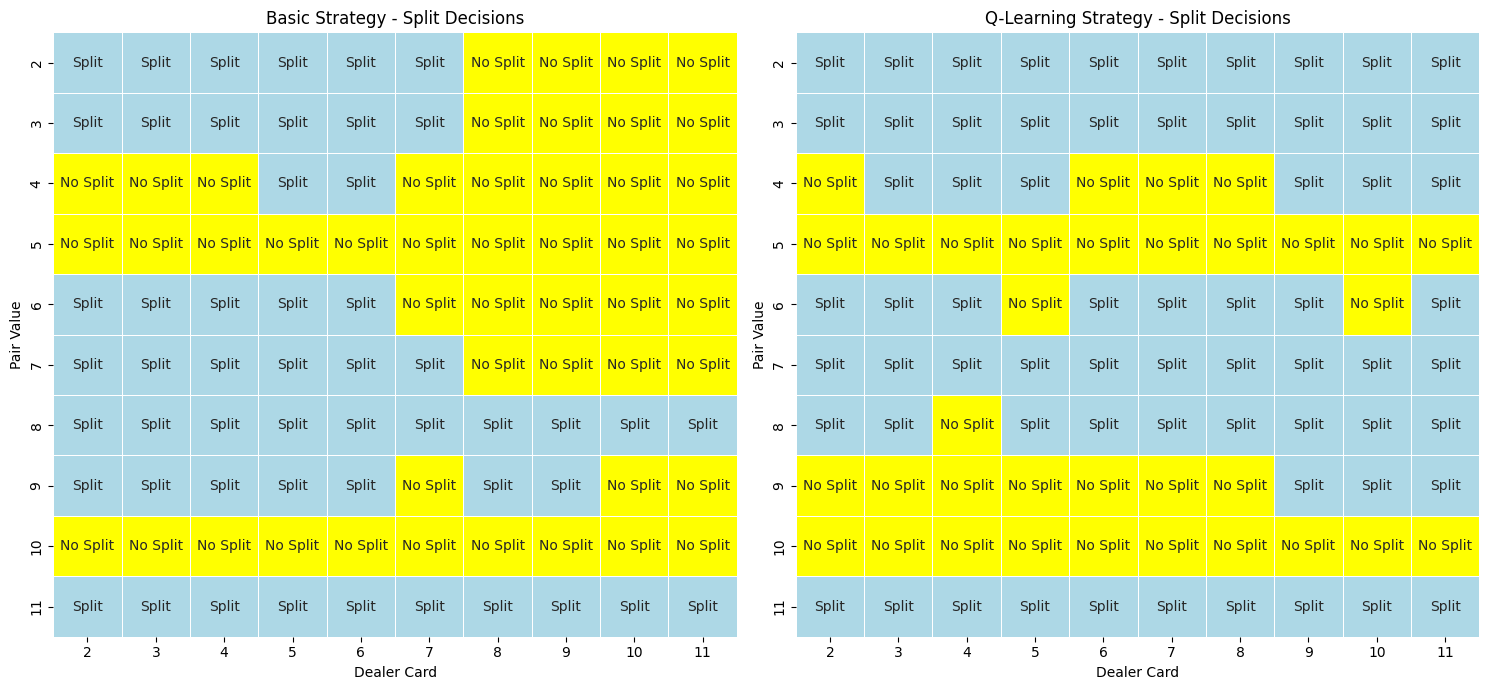

In [36]:
visualize_split('basic_split_strat.csv', 'split_strat.csv')